# Anomalous Sound Detection via Wav2Vec2 Sequence Autoencoder
Precompute full Wav2Vec2 embeddings, then train an LSTM+MLP autoencoder on those sequences.

In [25]:
# pip install torch torchaudio librosa tqdm scikit-learn


In [26]:
import os, glob
import torch
from torch import nn
import torchaudio
import matplotlib.pyplot as plt
import librosa, librosa.display
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import numpy as np

## DATA Examination

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TRAIN_DIR = 'DATA/dev_data/dev_data/slider/train'
TEST_DIR  = 'DATA/dev_data/dev_data/slider/test'
train_files = sorted(glob.glob(os.path.join(TRAIN_DIR, '*.wav')))
test_files  = sorted(glob.glob(os.path.join(TEST_DIR,  '*.wav')))
print('Train samples:', len(train_files))
print('Test samples:', len(test_files))
print('Example files:', train_files[:3])
total_dur = sum(librosa.get_duration(path=f) for f in tqdm(train_files, desc='Duration'))
print(f'Total train duration: {total_dur/3600:.2f} h')

Train samples: 2370
Test samples: 1101
Example files: ['DATA/dev_data/dev_data/slider/train\\normal_id_00_00000000.wav', 'DATA/dev_data/dev_data/slider/train\\normal_id_00_00000001.wav', 'DATA/dev_data/dev_data/slider/train\\normal_id_00_00000002.wav']


Duration: 100%|██████████| 2370/2370 [00:00<00:00, 5181.05it/s]

Total train duration: 6.58 h


## Pretrained Wav2Vec2 Encoder

In [29]:
bundle = torchaudio.pipelines.WAV2VEC2_BASE
wav2vec = bundle.get_model().to(DEVICE)
wav2vec.eval()
print(wav2vec)

Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      )
      (1-4): 4 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (5-6): 2 x ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
    )
  )
  (encoder): Encoder(
    (feature_projection): FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (pos_conv_embed): ConvolutionalPositionalEmbedding(
        (conv): ParametrizedConv1d(
          768, 768, kernel_size=(128,), stride=(1,), padding=(64,), groups=16
          (parametriza

## Offline Embeddings Generation

In [30]:
EMB_DIR = 'DATA/embeddings_seq'
os.makedirs(f'{EMB_DIR}/train', exist_ok=True)
os.makedirs(f'{EMB_DIR}/test',  exist_ok=True)
for split, files in [('train', train_files), ('test', test_files)]:
    out_folder = os.path.join(EMB_DIR, split)
    for wav in tqdm(files, desc=f'Emb {split}', leave=False):
        out_npy = os.path.join(out_folder, os.path.basename(wav).replace('.wav','.npy'))
        if os.path.exists(out_npy): continue
        y, sr = torchaudio.load(wav)
        y = y.to(DEVICE)
        with torch.inference_mode():
            feats, _ = wav2vec(y)
        seq = feats.squeeze(0).cpu().numpy()  # [T, 768]
        np.save(out_npy, seq)

## Sequence Embedding Dataset & DataLoader

In [31]:
class SeqEmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, folder):
        self.files = sorted(glob.glob(os.path.join(folder, '*.npy')))
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        seq = np.load(self.files[idx])
        x = torch.tensor(seq, dtype=torch.float32)
        label = 0 if 'normal' in self.files[idx].lower() else 1
        return x, label
train_ds = SeqEmbeddingDataset(f'{EMB_DIR}/train')
test_ds  = SeqEmbeddingDataset(f'{EMB_DIR}/test')
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=lambda b: b)
test_dl  = torch.utils.data.DataLoader(test_ds,  batch_size=64, shuffle=False, collate_fn=lambda b: b)

## Sequence Autoencoder (LSTM + MLP Decoder)

In [32]:
FEAT_DIM = 768
HIDDEN   = 256
class SeqAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.LSTM(FEAT_DIM, HIDDEN, batch_first=True)
        self.decoder = nn.LSTM(HIDDEN, HIDDEN, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(HIDDEN, 512), nn.ReLU(),
            nn.Linear(512, FEAT_DIM)
        )
    def forward(self, x):
        _, (h_n, _) = self.encoder(x)
        h = h_n[-1]
        T = x.size(1)
        dec_in = h.unsqueeze(1).repeat(1, T, 1)
        dec_out, _ = self.decoder(dec_in)
        return self.mlp(dec_out)
ae = SeqAE().to(DEVICE)
print(ae)

SeqAE(
  (encoder): LSTM(768, 256, batch_first=True)
  (decoder): LSTM(256, 256, batch_first=True)
  (mlp): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=768, bias=True)
  )
)


## Training Sequence Autoencoder

In [33]:
opt = torch.optim.Adam(ae.parameters(), lr=1e-3)
crit = nn.MSELoss()
EPOCHS = 500
for ep in range(1, EPOCHS+1):
    ae.train()
    total_loss = 0.0
    count = 0
    for batch in tqdm(train_dl, desc=f'Epoch {ep}/{EPOCHS}'):
        seqs, _ = zip(*batch)
        x = torch.nn.utils.rnn.pad_sequence(seqs, batch_first=True).to(DEVICE)
        mask = (x.abs().sum(-1)!=0).float()
        opt.zero_grad()
        out = ae(x)
        loss = ((out - x)**2 * mask.unsqueeze(-1)).sum() / mask.sum()
        loss.backward()
        opt.step()
        total_loss += loss.item() * len(batch)
        count += len(batch)
    print(f'Epoch {ep} avg_loss: {total_loss/count:.4f}')

Epoch 1/500: 100%|██████████| 38/38 [00:07<00:00,  4.97it/s]


Epoch 1 avg_loss: 26.5782


Epoch 2/500: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Epoch 2 avg_loss: 14.1024


Epoch 3/500: 100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


Epoch 3 avg_loss: 11.6281


Epoch 4/500: 100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


Epoch 4 avg_loss: 10.2001


Epoch 5/500: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Epoch 5 avg_loss: 9.3401


Epoch 6/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 6 avg_loss: 8.8661


Epoch 7/500: 100%|██████████| 38/38 [00:07<00:00,  4.91it/s]


Epoch 7 avg_loss: 8.3561


Epoch 8/500: 100%|██████████| 38/38 [00:07<00:00,  5.04it/s]


Epoch 8 avg_loss: 8.0843


Epoch 9/500: 100%|██████████| 38/38 [00:07<00:00,  5.39it/s]


Epoch 9 avg_loss: 7.7982


Epoch 10/500: 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


Epoch 10 avg_loss: 7.6030


Epoch 11/500: 100%|██████████| 38/38 [00:07<00:00,  5.07it/s]


Epoch 11 avg_loss: 7.4169


Epoch 12/500: 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


Epoch 12 avg_loss: 7.2794


Epoch 13/500: 100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


Epoch 13 avg_loss: 7.1228


Epoch 14/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 14 avg_loss: 7.0944


Epoch 15/500: 100%|██████████| 38/38 [00:07<00:00,  5.00it/s]


Epoch 15 avg_loss: 6.9682


Epoch 16/500: 100%|██████████| 38/38 [00:07<00:00,  5.38it/s]


Epoch 16 avg_loss: 6.8163


Epoch 17/500: 100%|██████████| 38/38 [00:07<00:00,  5.40it/s]


Epoch 17 avg_loss: 6.7597


Epoch 18/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 18 avg_loss: 6.7790


Epoch 19/500: 100%|██████████| 38/38 [00:07<00:00,  5.33it/s]


Epoch 19 avg_loss: 6.6322


Epoch 20/500: 100%|██████████| 38/38 [00:07<00:00,  5.31it/s]


Epoch 20 avg_loss: 6.5875


Epoch 21/500: 100%|██████████| 38/38 [00:07<00:00,  5.41it/s]


Epoch 21 avg_loss: 6.6989


Epoch 22/500: 100%|██████████| 38/38 [00:07<00:00,  5.35it/s]


Epoch 22 avg_loss: 6.5182


Epoch 23/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 23 avg_loss: 6.5208


Epoch 24/500: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Epoch 24 avg_loss: 6.5765


Epoch 25/500: 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


Epoch 25 avg_loss: 6.4446


Epoch 26/500: 100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


Epoch 26 avg_loss: 6.3668


Epoch 27/500: 100%|██████████| 38/38 [00:07<00:00,  5.05it/s]


Epoch 27 avg_loss: 6.3098


Epoch 28/500: 100%|██████████| 38/38 [00:07<00:00,  5.15it/s]


Epoch 28 avg_loss: 6.3358


Epoch 29/500: 100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


Epoch 29 avg_loss: 6.2823


Epoch 30/500: 100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


Epoch 30 avg_loss: 6.2303


Epoch 31/500: 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


Epoch 31 avg_loss: 6.2619


Epoch 32/500: 100%|██████████| 38/38 [00:07<00:00,  5.16it/s]


Epoch 32 avg_loss: 6.2888


Epoch 33/500: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Epoch 33 avg_loss: 6.3098


Epoch 34/500: 100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


Epoch 34 avg_loss: 6.2308


Epoch 35/500: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Epoch 35 avg_loss: 6.1367


Epoch 36/500: 100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


Epoch 36 avg_loss: 6.3147


Epoch 37/500: 100%|██████████| 38/38 [00:07<00:00,  5.32it/s]


Epoch 37 avg_loss: 6.1975


Epoch 38/500: 100%|██████████| 38/38 [00:07<00:00,  5.40it/s]


Epoch 38 avg_loss: 6.1233


Epoch 39/500: 100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


Epoch 39 avg_loss: 6.0479


Epoch 40/500: 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


Epoch 40 avg_loss: 6.0416


Epoch 41/500: 100%|██████████| 38/38 [00:07<00:00,  5.32it/s]


Epoch 41 avg_loss: 6.0392


Epoch 42/500: 100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


Epoch 42 avg_loss: 6.0618


Epoch 43/500: 100%|██████████| 38/38 [00:08<00:00,  4.47it/s]


Epoch 43 avg_loss: 6.1073


Epoch 44/500: 100%|██████████| 38/38 [00:09<00:00,  3.97it/s]


Epoch 44 avg_loss: 6.1137


Epoch 45/500: 100%|██████████| 38/38 [00:08<00:00,  4.51it/s]


Epoch 45 avg_loss: 6.0132


Epoch 46/500: 100%|██████████| 38/38 [00:08<00:00,  4.48it/s]


Epoch 46 avg_loss: 5.9961


Epoch 47/500: 100%|██████████| 38/38 [00:09<00:00,  3.88it/s]


Epoch 47 avg_loss: 5.9345


Epoch 48/500: 100%|██████████| 38/38 [00:08<00:00,  4.24it/s]


Epoch 48 avg_loss: 5.9869


Epoch 49/500: 100%|██████████| 38/38 [00:08<00:00,  4.71it/s]


Epoch 49 avg_loss: 5.9733


Epoch 50/500: 100%|██████████| 38/38 [00:10<00:00,  3.52it/s]


Epoch 50 avg_loss: 5.9838


Epoch 51/500: 100%|██████████| 38/38 [00:08<00:00,  4.37it/s]


Epoch 51 avg_loss: 6.0008


Epoch 52/500: 100%|██████████| 38/38 [00:08<00:00,  4.73it/s]


Epoch 52 avg_loss: 6.0251


Epoch 53/500: 100%|██████████| 38/38 [00:08<00:00,  4.61it/s]


Epoch 53 avg_loss: 6.0921


Epoch 54/500: 100%|██████████| 38/38 [00:08<00:00,  4.64it/s]


Epoch 54 avg_loss: 6.1058


Epoch 55/500: 100%|██████████| 38/38 [00:08<00:00,  4.61it/s]


Epoch 55 avg_loss: 6.0061


Epoch 56/500: 100%|██████████| 38/38 [00:07<00:00,  4.77it/s]


Epoch 56 avg_loss: 5.9355


Epoch 57/500: 100%|██████████| 38/38 [00:08<00:00,  4.73it/s]


Epoch 57 avg_loss: 5.8688


Epoch 58/500: 100%|██████████| 38/38 [00:07<00:00,  4.86it/s]


Epoch 58 avg_loss: 5.8951


Epoch 59/500: 100%|██████████| 38/38 [00:07<00:00,  4.97it/s]


Epoch 59 avg_loss: 5.9083


Epoch 60/500: 100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


Epoch 60 avg_loss: 5.8754


Epoch 61/500: 100%|██████████| 38/38 [00:07<00:00,  5.02it/s]


Epoch 61 avg_loss: 5.8521


Epoch 62/500: 100%|██████████| 38/38 [00:07<00:00,  5.02it/s]


Epoch 62 avg_loss: 5.8827


Epoch 63/500: 100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


Epoch 63 avg_loss: 5.8847


Epoch 64/500: 100%|██████████| 38/38 [00:07<00:00,  4.97it/s]


Epoch 64 avg_loss: 5.8575


Epoch 65/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 65 avg_loss: 5.8136


Epoch 66/500: 100%|██████████| 38/38 [00:07<00:00,  5.03it/s]


Epoch 66 avg_loss: 5.8596


Epoch 67/500: 100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


Epoch 67 avg_loss: 5.8312


Epoch 68/500: 100%|██████████| 38/38 [00:07<00:00,  4.87it/s]


Epoch 68 avg_loss: 5.8029


Epoch 69/500: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Epoch 69 avg_loss: 5.7966


Epoch 70/500: 100%|██████████| 38/38 [00:07<00:00,  5.30it/s]


Epoch 70 avg_loss: 5.7695


Epoch 71/500: 100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


Epoch 71 avg_loss: 5.8091


Epoch 72/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 72 avg_loss: 5.7608


Epoch 73/500: 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


Epoch 73 avg_loss: 5.7753


Epoch 74/500: 100%|██████████| 38/38 [00:07<00:00,  5.42it/s]


Epoch 74 avg_loss: 5.7902


Epoch 75/500: 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


Epoch 75 avg_loss: 5.7944


Epoch 76/500: 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


Epoch 76 avg_loss: 5.7898


Epoch 77/500: 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


Epoch 77 avg_loss: 5.7744


Epoch 78/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 78 avg_loss: 5.8136


Epoch 79/500: 100%|██████████| 38/38 [00:07<00:00,  5.40it/s]


Epoch 79 avg_loss: 5.7915


Epoch 80/500: 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


Epoch 80 avg_loss: 5.7614


Epoch 81/500: 100%|██████████| 38/38 [00:07<00:00,  5.39it/s]


Epoch 81 avg_loss: 5.7208


Epoch 82/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 82 avg_loss: 5.8188


Epoch 83/500: 100%|██████████| 38/38 [00:07<00:00,  5.32it/s]


Epoch 83 avg_loss: 5.7894


Epoch 84/500: 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


Epoch 84 avg_loss: 5.7651


Epoch 85/500: 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


Epoch 85 avg_loss: 5.7335


Epoch 86/500: 100%|██████████| 38/38 [00:07<00:00,  5.35it/s]


Epoch 86 avg_loss: 5.7071


Epoch 87/500: 100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


Epoch 87 avg_loss: 5.7895


Epoch 88/500: 100%|██████████| 38/38 [00:07<00:00,  5.31it/s]


Epoch 88 avg_loss: 5.8064


Epoch 89/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 89 avg_loss: 5.7745


Epoch 90/500: 100%|██████████| 38/38 [00:07<00:00,  5.31it/s]


Epoch 90 avg_loss: 5.8039


Epoch 91/500: 100%|██████████| 38/38 [00:07<00:00,  5.37it/s]


Epoch 91 avg_loss: 5.7690


Epoch 92/500: 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


Epoch 92 avg_loss: 5.7206


Epoch 93/500: 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


Epoch 93 avg_loss: 5.6982


Epoch 94/500: 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


Epoch 94 avg_loss: 5.7137


Epoch 95/500: 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


Epoch 95 avg_loss: 5.6843


Epoch 96/500: 100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


Epoch 96 avg_loss: 5.6835


Epoch 97/500: 100%|██████████| 38/38 [00:07<00:00,  5.39it/s]


Epoch 97 avg_loss: 5.6584


Epoch 98/500: 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


Epoch 98 avg_loss: 5.6877


Epoch 99/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 99 avg_loss: 5.9421


Epoch 100/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 100 avg_loss: 5.8429


Epoch 101/500: 100%|██████████| 38/38 [00:07<00:00,  5.31it/s]


Epoch 101 avg_loss: 5.7728


Epoch 102/500: 100%|██████████| 38/38 [00:07<00:00,  5.33it/s]


Epoch 102 avg_loss: 5.7588


Epoch 103/500: 100%|██████████| 38/38 [00:07<00:00,  5.31it/s]


Epoch 103 avg_loss: 5.6923


Epoch 104/500: 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


Epoch 104 avg_loss: 5.7224


Epoch 105/500: 100%|██████████| 38/38 [00:07<00:00,  5.32it/s]


Epoch 105 avg_loss: 5.7076


Epoch 106/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 106 avg_loss: 5.7136


Epoch 107/500: 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


Epoch 107 avg_loss: 5.7509


Epoch 108/500: 100%|██████████| 38/38 [00:07<00:00,  5.41it/s]


Epoch 108 avg_loss: 5.7012


Epoch 109/500: 100%|██████████| 38/38 [00:07<00:00,  5.40it/s]


Epoch 109 avg_loss: 5.6640


Epoch 110/500: 100%|██████████| 38/38 [00:07<00:00,  5.43it/s]


Epoch 110 avg_loss: 5.6870


Epoch 111/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 111 avg_loss: 5.7462


Epoch 112/500: 100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


Epoch 112 avg_loss: 5.6823


Epoch 113/500: 100%|██████████| 38/38 [00:06<00:00,  5.43it/s]


Epoch 113 avg_loss: 5.6428


Epoch 114/500: 100%|██████████| 38/38 [00:06<00:00,  5.49it/s]


Epoch 114 avg_loss: 5.6774


Epoch 115/500: 100%|██████████| 38/38 [00:07<00:00,  5.31it/s]


Epoch 115 avg_loss: 5.6602


Epoch 116/500: 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


Epoch 116 avg_loss: 5.6525


Epoch 117/500: 100%|██████████| 38/38 [00:07<00:00,  5.41it/s]


Epoch 117 avg_loss: 5.6383


Epoch 118/500: 100%|██████████| 38/38 [00:07<00:00,  5.41it/s]


Epoch 118 avg_loss: 5.6907


Epoch 119/500: 100%|██████████| 38/38 [00:07<00:00,  5.37it/s]


Epoch 119 avg_loss: 5.6602


Epoch 120/500: 100%|██████████| 38/38 [00:07<00:00,  5.37it/s]


Epoch 120 avg_loss: 5.6542


Epoch 121/500: 100%|██████████| 38/38 [00:07<00:00,  5.39it/s]


Epoch 121 avg_loss: 5.6559


Epoch 122/500: 100%|██████████| 38/38 [00:07<00:00,  5.33it/s]


Epoch 122 avg_loss: 5.6269


Epoch 123/500: 100%|██████████| 38/38 [00:07<00:00,  4.93it/s]


Epoch 123 avg_loss: 5.6093


Epoch 124/500: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Epoch 124 avg_loss: 5.5861


Epoch 125/500: 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


Epoch 125 avg_loss: 5.6031


Epoch 126/500: 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


Epoch 126 avg_loss: 5.6103


Epoch 127/500: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Epoch 127 avg_loss: 5.6130


Epoch 128/500: 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


Epoch 128 avg_loss: 5.5939


Epoch 129/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 129 avg_loss: 5.6004


Epoch 130/500: 100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


Epoch 130 avg_loss: 5.5901


Epoch 131/500: 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


Epoch 131 avg_loss: 5.5683


Epoch 132/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 132 avg_loss: 5.5741


Epoch 133/500: 100%|██████████| 38/38 [00:07<00:00,  5.32it/s]


Epoch 133 avg_loss: 5.6414


Epoch 134/500: 100%|██████████| 38/38 [00:07<00:00,  5.08it/s]


Epoch 134 avg_loss: 5.7623


Epoch 135/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 135 avg_loss: 5.6649


Epoch 136/500: 100%|██████████| 38/38 [00:07<00:00,  5.15it/s]


Epoch 136 avg_loss: 5.6556


Epoch 137/500: 100%|██████████| 38/38 [00:07<00:00,  5.12it/s]


Epoch 137 avg_loss: 5.6565


Epoch 138/500: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Epoch 138 avg_loss: 5.6084


Epoch 139/500: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Epoch 139 avg_loss: 5.5805


Epoch 140/500: 100%|██████████| 38/38 [00:07<00:00,  5.14it/s]


Epoch 140 avg_loss: 5.5774


Epoch 141/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 141 avg_loss: 5.5927


Epoch 142/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 142 avg_loss: 5.6279


Epoch 143/500: 100%|██████████| 38/38 [00:07<00:00,  5.30it/s]


Epoch 143 avg_loss: 5.6543


Epoch 144/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 144 avg_loss: 5.6686


Epoch 145/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 145 avg_loss: 5.5902


Epoch 146/500: 100%|██████████| 38/38 [00:07<00:00,  5.15it/s]


Epoch 146 avg_loss: 5.6099


Epoch 147/500: 100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


Epoch 147 avg_loss: 5.6152


Epoch 148/500: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Epoch 148 avg_loss: 5.6990


Epoch 149/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 149 avg_loss: 5.5774


Epoch 150/500: 100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


Epoch 150 avg_loss: 5.6880


Epoch 151/500: 100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


Epoch 151 avg_loss: 5.6354


Epoch 152/500: 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


Epoch 152 avg_loss: 5.5990


Epoch 153/500: 100%|██████████| 38/38 [00:07<00:00,  5.07it/s]


Epoch 153 avg_loss: 5.5872


Epoch 154/500: 100%|██████████| 38/38 [00:07<00:00,  5.05it/s]


Epoch 154 avg_loss: 5.6219


Epoch 155/500: 100%|██████████| 38/38 [00:07<00:00,  5.31it/s]


Epoch 155 avg_loss: 5.5503


Epoch 156/500: 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


Epoch 156 avg_loss: 5.5492


Epoch 157/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 157 avg_loss: 5.5780


Epoch 158/500: 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


Epoch 158 avg_loss: 5.5649


Epoch 159/500: 100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


Epoch 159 avg_loss: 5.5390


Epoch 160/500: 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


Epoch 160 avg_loss: 5.5388


Epoch 161/500: 100%|██████████| 38/38 [00:07<00:00,  5.23it/s]


Epoch 161 avg_loss: 5.5489


Epoch 162/500: 100%|██████████| 38/38 [00:07<00:00,  5.26it/s]


Epoch 162 avg_loss: 5.5942


Epoch 163/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 163 avg_loss: 5.6094


Epoch 164/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 164 avg_loss: 5.6341


Epoch 165/500: 100%|██████████| 38/38 [00:07<00:00,  5.30it/s]


Epoch 165 avg_loss: 5.6362


Epoch 166/500: 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


Epoch 166 avg_loss: 5.5869


Epoch 167/500: 100%|██████████| 38/38 [00:07<00:00,  5.30it/s]


Epoch 167 avg_loss: 5.5485


Epoch 168/500: 100%|██████████| 38/38 [00:07<00:00,  5.30it/s]


Epoch 168 avg_loss: 5.5704


Epoch 169/500: 100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


Epoch 169 avg_loss: 5.5411


Epoch 170/500: 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


Epoch 170 avg_loss: 5.5236


Epoch 171/500: 100%|██████████| 38/38 [00:07<00:00,  5.40it/s]


Epoch 171 avg_loss: 5.5386


Epoch 172/500: 100%|██████████| 38/38 [00:07<00:00,  4.98it/s]


Epoch 172 avg_loss: 5.5571


Epoch 173/500: 100%|██████████| 38/38 [00:07<00:00,  5.26it/s]


Epoch 173 avg_loss: 5.5850


Epoch 174/500: 100%|██████████| 38/38 [00:07<00:00,  5.31it/s]


Epoch 174 avg_loss: 5.5378


Epoch 175/500: 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


Epoch 175 avg_loss: 5.5339


Epoch 176/500: 100%|██████████| 38/38 [00:07<00:00,  5.31it/s]


Epoch 176 avg_loss: 5.5637


Epoch 177/500: 100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


Epoch 177 avg_loss: 5.5760


Epoch 178/500: 100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


Epoch 178 avg_loss: 5.5467


Epoch 179/500: 100%|██████████| 38/38 [00:06<00:00,  5.47it/s]


Epoch 179 avg_loss: 5.5310


Epoch 180/500: 100%|██████████| 38/38 [00:06<00:00,  5.48it/s]


Epoch 180 avg_loss: 5.5100


Epoch 181/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 181 avg_loss: 5.5569


Epoch 182/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 182 avg_loss: 5.5327


Epoch 183/500: 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


Epoch 183 avg_loss: 5.5149


Epoch 184/500: 100%|██████████| 38/38 [00:07<00:00,  5.40it/s]


Epoch 184 avg_loss: 5.5234


Epoch 185/500: 100%|██████████| 38/38 [00:07<00:00,  5.42it/s]


Epoch 185 avg_loss: 5.5639


Epoch 186/500: 100%|██████████| 38/38 [00:07<00:00,  5.30it/s]


Epoch 186 avg_loss: 5.6568


Epoch 187/500: 100%|██████████| 38/38 [00:06<00:00,  5.45it/s]


Epoch 187 avg_loss: 5.6476


Epoch 188/500: 100%|██████████| 38/38 [00:07<00:00,  5.41it/s]


Epoch 188 avg_loss: 5.6171


Epoch 189/500: 100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


Epoch 189 avg_loss: 5.5905


Epoch 190/500: 100%|██████████| 38/38 [00:07<00:00,  5.38it/s]


Epoch 190 avg_loss: 5.5797


Epoch 191/500: 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


Epoch 191 avg_loss: 5.8003


Epoch 192/500: 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


Epoch 192 avg_loss: 5.7225


Epoch 193/500: 100%|██████████| 38/38 [00:07<00:00,  5.30it/s]


Epoch 193 avg_loss: 5.6468


Epoch 194/500: 100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


Epoch 194 avg_loss: 5.5803


Epoch 195/500: 100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


Epoch 195 avg_loss: 5.5159


Epoch 196/500: 100%|██████████| 38/38 [00:07<00:00,  5.32it/s]


Epoch 196 avg_loss: 5.5425


Epoch 197/500: 100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


Epoch 197 avg_loss: 5.4900


Epoch 198/500: 100%|██████████| 38/38 [00:07<00:00,  5.33it/s]


Epoch 198 avg_loss: 5.5144


Epoch 199/500: 100%|██████████| 38/38 [00:07<00:00,  5.41it/s]


Epoch 199 avg_loss: 5.4873


Epoch 200/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 200 avg_loss: 5.4934


Epoch 201/500: 100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


Epoch 201 avg_loss: 5.7017


Epoch 202/500: 100%|██████████| 38/38 [00:07<00:00,  5.31it/s]


Epoch 202 avg_loss: 5.5865


Epoch 203/500: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Epoch 203 avg_loss: 5.5322


Epoch 204/500: 100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


Epoch 204 avg_loss: 5.4937


Epoch 205/500: 100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


Epoch 205 avg_loss: 5.5338


Epoch 206/500: 100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


Epoch 206 avg_loss: 5.5202


Epoch 207/500: 100%|██████████| 38/38 [00:07<00:00,  5.16it/s]


Epoch 207 avg_loss: 5.4954


Epoch 208/500: 100%|██████████| 38/38 [00:07<00:00,  5.03it/s]


Epoch 208 avg_loss: 5.4979


Epoch 209/500: 100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


Epoch 209 avg_loss: 5.4932


Epoch 210/500: 100%|██████████| 38/38 [00:07<00:00,  5.08it/s]


Epoch 210 avg_loss: 5.5410


Epoch 211/500: 100%|██████████| 38/38 [00:07<00:00,  5.12it/s]


Epoch 211 avg_loss: 5.4790


Epoch 212/500: 100%|██████████| 38/38 [00:07<00:00,  5.08it/s]


Epoch 212 avg_loss: 5.4758


Epoch 213/500: 100%|██████████| 38/38 [00:07<00:00,  5.10it/s]


Epoch 213 avg_loss: 5.4966


Epoch 214/500: 100%|██████████| 38/38 [00:07<00:00,  5.05it/s]


Epoch 214 avg_loss: 5.5478


Epoch 215/500: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Epoch 215 avg_loss: 5.5364


Epoch 216/500: 100%|██████████| 38/38 [00:07<00:00,  5.15it/s]


Epoch 216 avg_loss: 5.4644


Epoch 217/500: 100%|██████████| 38/38 [00:07<00:00,  4.92it/s]


Epoch 217 avg_loss: 5.4468


Epoch 218/500: 100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


Epoch 218 avg_loss: 5.5083


Epoch 219/500: 100%|██████████| 38/38 [00:07<00:00,  4.88it/s]


Epoch 219 avg_loss: 5.4748


Epoch 220/500: 100%|██████████| 38/38 [00:07<00:00,  4.90it/s]


Epoch 220 avg_loss: 5.4549


Epoch 221/500: 100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


Epoch 221 avg_loss: 5.4302


Epoch 222/500: 100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


Epoch 222 avg_loss: 5.4447


Epoch 223/500: 100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


Epoch 223 avg_loss: 5.4807


Epoch 224/500: 100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


Epoch 224 avg_loss: 5.5750


Epoch 225/500: 100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


Epoch 225 avg_loss: 5.4846


Epoch 226/500: 100%|██████████| 38/38 [00:07<00:00,  5.03it/s]


Epoch 226 avg_loss: 5.4397


Epoch 227/500: 100%|██████████| 38/38 [00:07<00:00,  4.93it/s]


Epoch 227 avg_loss: 5.4397


Epoch 228/500: 100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


Epoch 228 avg_loss: 5.4569


Epoch 229/500: 100%|██████████| 38/38 [00:08<00:00,  4.28it/s]


Epoch 229 avg_loss: 5.4211


Epoch 230/500: 100%|██████████| 38/38 [00:09<00:00,  4.11it/s]


Epoch 230 avg_loss: 5.4460


Epoch 231/500: 100%|██████████| 38/38 [00:08<00:00,  4.34it/s]


Epoch 231 avg_loss: 5.4617


Epoch 232/500: 100%|██████████| 38/38 [00:08<00:00,  4.37it/s]


Epoch 232 avg_loss: 5.4339


Epoch 233/500: 100%|██████████| 38/38 [00:07<00:00,  5.08it/s]


Epoch 233 avg_loss: 5.4414


Epoch 234/500: 100%|██████████| 38/38 [00:07<00:00,  5.15it/s]


Epoch 234 avg_loss: 5.4046


Epoch 235/500: 100%|██████████| 38/38 [00:07<00:00,  5.26it/s]


Epoch 235 avg_loss: 5.4272


Epoch 236/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 236 avg_loss: 5.4192


Epoch 237/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 237 avg_loss: 5.4203


Epoch 238/500: 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


Epoch 238 avg_loss: 5.5880


Epoch 239/500: 100%|██████████| 38/38 [00:07<00:00,  5.33it/s]


Epoch 239 avg_loss: 5.5405


Epoch 240/500: 100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


Epoch 240 avg_loss: 5.4502


Epoch 241/500: 100%|██████████| 38/38 [00:07<00:00,  5.30it/s]


Epoch 241 avg_loss: 5.4478


Epoch 242/500: 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


Epoch 242 avg_loss: 5.4194


Epoch 243/500: 100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


Epoch 243 avg_loss: 5.4035


Epoch 244/500: 100%|██████████| 38/38 [00:07<00:00,  5.16it/s]


Epoch 244 avg_loss: 5.3993


Epoch 245/500: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Epoch 245 avg_loss: 5.3705


Epoch 246/500: 100%|██████████| 38/38 [00:07<00:00,  5.16it/s]


Epoch 246 avg_loss: 5.3779


Epoch 247/500: 100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


Epoch 247 avg_loss: 5.3773


Epoch 248/500: 100%|██████████| 38/38 [00:07<00:00,  5.16it/s]


Epoch 248 avg_loss: 5.3797


Epoch 249/500: 100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


Epoch 249 avg_loss: 5.3981


Epoch 250/500: 100%|██████████| 38/38 [00:07<00:00,  5.07it/s]


Epoch 250 avg_loss: 5.3829


Epoch 251/500: 100%|██████████| 38/38 [00:07<00:00,  5.37it/s]


Epoch 251 avg_loss: 5.4511


Epoch 252/500: 100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


Epoch 252 avg_loss: 5.3944


Epoch 253/500: 100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


Epoch 253 avg_loss: 5.3936


Epoch 254/500: 100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


Epoch 254 avg_loss: 5.3611


Epoch 255/500: 100%|██████████| 38/38 [00:07<00:00,  5.31it/s]


Epoch 255 avg_loss: 5.3696


Epoch 256/500: 100%|██████████| 38/38 [00:07<00:00,  5.04it/s]


Epoch 256 avg_loss: 5.4290


Epoch 257/500: 100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


Epoch 257 avg_loss: 5.3808


Epoch 258/500: 100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


Epoch 258 avg_loss: 5.3601


Epoch 259/500: 100%|██████████| 38/38 [00:07<00:00,  5.08it/s]


Epoch 259 avg_loss: 5.3720


Epoch 260/500: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Epoch 260 avg_loss: 5.3693


Epoch 261/500: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Epoch 261 avg_loss: 5.3544


Epoch 262/500: 100%|██████████| 38/38 [00:07<00:00,  5.26it/s]


Epoch 262 avg_loss: 5.4008


Epoch 263/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 263 avg_loss: 5.4268


Epoch 264/500: 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


Epoch 264 avg_loss: 5.3682


Epoch 265/500: 100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


Epoch 265 avg_loss: 5.3623


Epoch 266/500: 100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


Epoch 266 avg_loss: 5.3348


Epoch 267/500: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Epoch 267 avg_loss: 5.4671


Epoch 268/500: 100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


Epoch 268 avg_loss: 5.4749


Epoch 269/500: 100%|██████████| 38/38 [00:07<00:00,  5.23it/s]


Epoch 269 avg_loss: 5.4047


Epoch 270/500: 100%|██████████| 38/38 [00:07<00:00,  5.33it/s]


Epoch 270 avg_loss: 5.3974


Epoch 271/500: 100%|██████████| 38/38 [00:07<00:00,  5.31it/s]


Epoch 271 avg_loss: 5.4343


Epoch 272/500: 100%|██████████| 38/38 [00:07<00:00,  5.14it/s]


Epoch 272 avg_loss: 5.3629


Epoch 273/500: 100%|██████████| 38/38 [00:07<00:00,  5.23it/s]


Epoch 273 avg_loss: 5.4020


Epoch 274/500: 100%|██████████| 38/38 [00:07<00:00,  5.33it/s]


Epoch 274 avg_loss: 5.3753


Epoch 275/500: 100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


Epoch 275 avg_loss: 5.3329


Epoch 276/500: 100%|██████████| 38/38 [00:07<00:00,  5.26it/s]


Epoch 276 avg_loss: 5.3285


Epoch 277/500: 100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


Epoch 277 avg_loss: 5.3954


Epoch 278/500: 100%|██████████| 38/38 [00:07<00:00,  5.30it/s]


Epoch 278 avg_loss: 5.3435


Epoch 279/500: 100%|██████████| 38/38 [00:07<00:00,  5.23it/s]


Epoch 279 avg_loss: 5.3267


Epoch 280/500: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Epoch 280 avg_loss: 5.3565


Epoch 281/500: 100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


Epoch 281 avg_loss: 5.3385


Epoch 282/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 282 avg_loss: 5.3422


Epoch 283/500: 100%|██████████| 38/38 [00:07<00:00,  5.30it/s]


Epoch 283 avg_loss: 5.3428


Epoch 284/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 284 avg_loss: 5.3199


Epoch 285/500: 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


Epoch 285 avg_loss: 5.3163


Epoch 286/500: 100%|██████████| 38/38 [00:07<00:00,  4.93it/s]


Epoch 286 avg_loss: 5.3978


Epoch 287/500: 100%|██████████| 38/38 [00:07<00:00,  5.04it/s]


Epoch 287 avg_loss: 5.6217


Epoch 288/500: 100%|██████████| 38/38 [00:07<00:00,  5.16it/s]


Epoch 288 avg_loss: 5.4244


Epoch 289/500: 100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


Epoch 289 avg_loss: 5.4440


Epoch 290/500: 100%|██████████| 38/38 [00:07<00:00,  4.96it/s]


Epoch 290 avg_loss: 5.4664


Epoch 291/500: 100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


Epoch 291 avg_loss: 5.3914


Epoch 292/500: 100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


Epoch 292 avg_loss: 5.3211


Epoch 293/500: 100%|██████████| 38/38 [00:07<00:00,  5.05it/s]


Epoch 293 avg_loss: 5.3220


Epoch 294/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 294 avg_loss: 5.3255


Epoch 295/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 295 avg_loss: 5.3278


Epoch 296/500: 100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


Epoch 296 avg_loss: 5.2854


Epoch 297/500: 100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


Epoch 297 avg_loss: 5.3153


Epoch 298/500: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Epoch 298 avg_loss: 5.3163


Epoch 299/500: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Epoch 299 avg_loss: 5.2945


Epoch 300/500: 100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


Epoch 300 avg_loss: 5.3397


Epoch 301/500: 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


Epoch 301 avg_loss: 5.3786


Epoch 302/500: 100%|██████████| 38/38 [00:07<00:00,  5.16it/s]


Epoch 302 avg_loss: 5.3181


Epoch 303/500: 100%|██████████| 38/38 [00:07<00:00,  5.12it/s]


Epoch 303 avg_loss: 5.2757


Epoch 304/500: 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


Epoch 304 avg_loss: 5.4305


Epoch 305/500: 100%|██████████| 38/38 [00:07<00:00,  5.30it/s]


Epoch 305 avg_loss: 5.3183


Epoch 306/500: 100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


Epoch 306 avg_loss: 5.3321


Epoch 307/500: 100%|██████████| 38/38 [00:07<00:00,  4.83it/s]


Epoch 307 avg_loss: 5.2954


Epoch 308/500: 100%|██████████| 38/38 [00:07<00:00,  4.79it/s]


Epoch 308 avg_loss: 5.2994


Epoch 309/500: 100%|██████████| 38/38 [00:07<00:00,  5.08it/s]


Epoch 309 avg_loss: 5.2611


Epoch 310/500: 100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


Epoch 310 avg_loss: 5.2821


Epoch 311/500: 100%|██████████| 38/38 [00:07<00:00,  5.23it/s]


Epoch 311 avg_loss: 5.2786


Epoch 312/500: 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


Epoch 312 avg_loss: 5.5960


Epoch 313/500: 100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


Epoch 313 avg_loss: 5.4360


Epoch 314/500: 100%|██████████| 38/38 [00:07<00:00,  4.91it/s]


Epoch 314 avg_loss: 5.3322


Epoch 315/500: 100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


Epoch 315 avg_loss: 5.3721


Epoch 316/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 316 avg_loss: 5.3536


Epoch 317/500: 100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


Epoch 317 avg_loss: 5.3122


Epoch 318/500: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Epoch 318 avg_loss: 5.2750


Epoch 319/500: 100%|██████████| 38/38 [00:07<00:00,  5.33it/s]


Epoch 319 avg_loss: 5.2988


Epoch 320/500: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Epoch 320 avg_loss: 5.3401


Epoch 321/500: 100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


Epoch 321 avg_loss: 5.3029


Epoch 322/500: 100%|██████████| 38/38 [00:07<00:00,  5.16it/s]


Epoch 322 avg_loss: 5.2505


Epoch 323/500: 100%|██████████| 38/38 [00:07<00:00,  5.14it/s]


Epoch 323 avg_loss: 5.2474


Epoch 324/500: 100%|██████████| 38/38 [00:07<00:00,  5.07it/s]


Epoch 324 avg_loss: 5.2712


Epoch 325/500: 100%|██████████| 38/38 [00:07<00:00,  5.05it/s]


Epoch 325 avg_loss: 5.2607


Epoch 326/500: 100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


Epoch 326 avg_loss: 5.2601


Epoch 327/500: 100%|██████████| 38/38 [00:07<00:00,  5.03it/s]


Epoch 327 avg_loss: 5.3062


Epoch 328/500: 100%|██████████| 38/38 [00:07<00:00,  5.10it/s]


Epoch 328 avg_loss: 5.2567


Epoch 329/500: 100%|██████████| 38/38 [00:07<00:00,  4.82it/s]


Epoch 329 avg_loss: 5.2696


Epoch 330/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 330 avg_loss: 5.2420


Epoch 331/500: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Epoch 331 avg_loss: 5.2460


Epoch 332/500: 100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


Epoch 332 avg_loss: 5.2243


Epoch 333/500: 100%|██████████| 38/38 [00:07<00:00,  5.15it/s]


Epoch 333 avg_loss: 5.2227


Epoch 334/500: 100%|██████████| 38/38 [00:07<00:00,  5.23it/s]


Epoch 334 avg_loss: 5.2595


Epoch 335/500: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Epoch 335 avg_loss: 5.2504


Epoch 336/500: 100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


Epoch 336 avg_loss: 5.2630


Epoch 337/500: 100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


Epoch 337 avg_loss: 5.2512


Epoch 338/500: 100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


Epoch 338 avg_loss: 5.2632


Epoch 339/500: 100%|██████████| 38/38 [00:07<00:00,  5.14it/s]


Epoch 339 avg_loss: 5.2501


Epoch 340/500: 100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


Epoch 340 avg_loss: 5.2879


Epoch 341/500: 100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


Epoch 341 avg_loss: 5.3724


Epoch 342/500: 100%|██████████| 38/38 [00:07<00:00,  5.14it/s]


Epoch 342 avg_loss: 5.2542


Epoch 343/500: 100%|██████████| 38/38 [00:07<00:00,  5.04it/s]


Epoch 343 avg_loss: 5.2550


Epoch 344/500: 100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


Epoch 344 avg_loss: 5.3111


Epoch 345/500: 100%|██████████| 38/38 [00:07<00:00,  5.12it/s]


Epoch 345 avg_loss: 5.4079


Epoch 346/500: 100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


Epoch 346 avg_loss: 5.3137


Epoch 347/500: 100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


Epoch 347 avg_loss: 5.3978


Epoch 348/500: 100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


Epoch 348 avg_loss: 5.4563


Epoch 349/500: 100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


Epoch 349 avg_loss: 5.2882


Epoch 350/500: 100%|██████████| 38/38 [00:07<00:00,  5.08it/s]


Epoch 350 avg_loss: 5.2853


Epoch 351/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 351 avg_loss: 5.2670


Epoch 352/500: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Epoch 352 avg_loss: 5.3573


Epoch 353/500: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Epoch 353 avg_loss: 5.2812


Epoch 354/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 354 avg_loss: 5.2628


Epoch 355/500: 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


Epoch 355 avg_loss: 5.3613


Epoch 356/500: 100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


Epoch 356 avg_loss: 5.2933


Epoch 357/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 357 avg_loss: 5.2560


Epoch 358/500: 100%|██████████| 38/38 [00:07<00:00,  5.26it/s]


Epoch 358 avg_loss: 5.2393


Epoch 359/500: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Epoch 359 avg_loss: 5.2410


Epoch 360/500: 100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


Epoch 360 avg_loss: 5.2010


Epoch 361/500: 100%|██████████| 38/38 [00:07<00:00,  5.12it/s]


Epoch 361 avg_loss: 5.2139


Epoch 362/500: 100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


Epoch 362 avg_loss: 5.2183


Epoch 363/500: 100%|██████████| 38/38 [00:07<00:00,  5.16it/s]


Epoch 363 avg_loss: 5.2664


Epoch 364/500: 100%|██████████| 38/38 [00:07<00:00,  5.14it/s]


Epoch 364 avg_loss: 5.1921


Epoch 365/500: 100%|██████████| 38/38 [00:07<00:00,  5.16it/s]


Epoch 365 avg_loss: 5.3432


Epoch 366/500: 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


Epoch 366 avg_loss: 5.2620


Epoch 367/500: 100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


Epoch 367 avg_loss: 5.2233


Epoch 368/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 368 avg_loss: 5.2359


Epoch 369/500: 100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


Epoch 369 avg_loss: 5.2159


Epoch 370/500: 100%|██████████| 38/38 [00:07<00:00,  5.15it/s]


Epoch 370 avg_loss: 5.2371


Epoch 371/500: 100%|██████████| 38/38 [00:07<00:00,  5.16it/s]


Epoch 371 avg_loss: 5.2110


Epoch 372/500: 100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


Epoch 372 avg_loss: 5.2162


Epoch 373/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 373 avg_loss: 5.1841


Epoch 374/500: 100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


Epoch 374 avg_loss: 5.1691


Epoch 375/500: 100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


Epoch 375 avg_loss: 5.2007


Epoch 376/500: 100%|██████████| 38/38 [00:07<00:00,  5.16it/s]


Epoch 376 avg_loss: 5.2164


Epoch 377/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 377 avg_loss: 5.2291


Epoch 378/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 378 avg_loss: 5.1869


Epoch 379/500: 100%|██████████| 38/38 [00:07<00:00,  5.26it/s]


Epoch 379 avg_loss: 5.1673


Epoch 380/500: 100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


Epoch 380 avg_loss: 5.2624


Epoch 381/500: 100%|██████████| 38/38 [00:07<00:00,  5.32it/s]


Epoch 381 avg_loss: 5.1795


Epoch 382/500: 100%|██████████| 38/38 [00:07<00:00,  5.23it/s]


Epoch 382 avg_loss: 5.1752


Epoch 383/500: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Epoch 383 avg_loss: 5.2427


Epoch 384/500: 100%|██████████| 38/38 [00:07<00:00,  5.26it/s]


Epoch 384 avg_loss: 5.2132


Epoch 385/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 385 avg_loss: 5.4402


Epoch 386/500: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Epoch 386 avg_loss: 5.2628


Epoch 387/500: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Epoch 387 avg_loss: 5.2390


Epoch 388/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 388 avg_loss: 5.2469


Epoch 389/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 389 avg_loss: 5.1884


Epoch 390/500: 100%|██████████| 38/38 [00:07<00:00,  5.15it/s]


Epoch 390 avg_loss: 5.1443


Epoch 391/500: 100%|██████████| 38/38 [00:07<00:00,  5.14it/s]


Epoch 391 avg_loss: 5.1717


Epoch 392/500: 100%|██████████| 38/38 [00:07<00:00,  5.14it/s]


Epoch 392 avg_loss: 5.1953


Epoch 393/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 393 avg_loss: 5.4858


Epoch 394/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 394 avg_loss: 5.5690


Epoch 395/500: 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


Epoch 395 avg_loss: 5.4307


Epoch 396/500: 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


Epoch 396 avg_loss: 5.2809


Epoch 397/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 397 avg_loss: 5.5637


Epoch 398/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 398 avg_loss: 5.3882


Epoch 399/500: 100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


Epoch 399 avg_loss: 5.3733


Epoch 400/500: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Epoch 400 avg_loss: 5.2908


Epoch 401/500: 100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


Epoch 401 avg_loss: 5.2563


Epoch 402/500: 100%|██████████| 38/38 [00:07<00:00,  5.05it/s]


Epoch 402 avg_loss: 5.2426


Epoch 403/500: 100%|██████████| 38/38 [00:07<00:00,  5.26it/s]


Epoch 403 avg_loss: 5.2001


Epoch 404/500: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Epoch 404 avg_loss: 5.2208


Epoch 405/500: 100%|██████████| 38/38 [00:07<00:00,  5.26it/s]


Epoch 405 avg_loss: 5.2337


Epoch 406/500: 100%|██████████| 38/38 [00:07<00:00,  5.31it/s]


Epoch 406 avg_loss: 5.2450


Epoch 407/500: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Epoch 407 avg_loss: 5.2677


Epoch 408/500: 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


Epoch 408 avg_loss: 5.1978


Epoch 409/500: 100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


Epoch 409 avg_loss: 5.1801


Epoch 410/500: 100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


Epoch 410 avg_loss: 5.1793


Epoch 411/500: 100%|██████████| 38/38 [00:08<00:00,  4.60it/s]


Epoch 411 avg_loss: 5.1665


Epoch 412/500: 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


Epoch 412 avg_loss: 5.1947


Epoch 413/500: 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


Epoch 413 avg_loss: 5.1863


Epoch 414/500: 100%|██████████| 38/38 [00:07<00:00,  4.80it/s]


Epoch 414 avg_loss: 5.2020


Epoch 415/500: 100%|██████████| 38/38 [00:07<00:00,  5.15it/s]


Epoch 415 avg_loss: 5.1303


Epoch 416/500: 100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


Epoch 416 avg_loss: 5.2541


Epoch 417/500: 100%|██████████| 38/38 [00:07<00:00,  4.85it/s]


Epoch 417 avg_loss: 5.2108


Epoch 418/500: 100%|██████████| 38/38 [00:07<00:00,  4.98it/s]


Epoch 418 avg_loss: 5.1627


Epoch 419/500: 100%|██████████| 38/38 [00:07<00:00,  5.04it/s]


Epoch 419 avg_loss: 5.1716


Epoch 420/500: 100%|██████████| 38/38 [00:07<00:00,  4.92it/s]


Epoch 420 avg_loss: 5.5226


Epoch 421/500: 100%|██████████| 38/38 [00:08<00:00,  4.51it/s]


Epoch 421 avg_loss: 5.2761


Epoch 422/500: 100%|██████████| 38/38 [00:07<00:00,  4.95it/s]


Epoch 422 avg_loss: 5.1645


Epoch 423/500: 100%|██████████| 38/38 [00:07<00:00,  5.23it/s]


Epoch 423 avg_loss: 5.1840


Epoch 424/500: 100%|██████████| 38/38 [00:07<00:00,  5.23it/s]


Epoch 424 avg_loss: 5.2041


Epoch 425/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 425 avg_loss: 5.1364


Epoch 426/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 426 avg_loss: 5.1503


Epoch 427/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 427 avg_loss: 5.1805


Epoch 428/500: 100%|██████████| 38/38 [00:07<00:00,  5.26it/s]


Epoch 428 avg_loss: 5.1301


Epoch 429/500: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Epoch 429 avg_loss: 5.1310


Epoch 430/500: 100%|██████████| 38/38 [00:07<00:00,  5.40it/s]


Epoch 430 avg_loss: 5.2610


Epoch 431/500: 100%|██████████| 38/38 [00:07<00:00,  5.30it/s]


Epoch 431 avg_loss: 5.2376


Epoch 432/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 432 avg_loss: 5.1629


Epoch 433/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 433 avg_loss: 5.2116


Epoch 434/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 434 avg_loss: 5.1500


Epoch 435/500: 100%|██████████| 38/38 [00:07<00:00,  5.15it/s]


Epoch 435 avg_loss: 5.1288


Epoch 436/500: 100%|██████████| 38/38 [00:07<00:00,  5.16it/s]


Epoch 436 avg_loss: 5.1114


Epoch 437/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 437 avg_loss: 5.1156


Epoch 438/500: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Epoch 438 avg_loss: 5.1055


Epoch 439/500: 100%|██████████| 38/38 [00:07<00:00,  5.33it/s]


Epoch 439 avg_loss: 5.1065


Epoch 440/500: 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


Epoch 440 avg_loss: 5.1412


Epoch 441/500: 100%|██████████| 38/38 [00:07<00:00,  5.30it/s]


Epoch 441 avg_loss: 5.1263


Epoch 442/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 442 avg_loss: 5.2497


Epoch 443/500: 100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


Epoch 443 avg_loss: 5.1212


Epoch 444/500: 100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


Epoch 444 avg_loss: 5.1260


Epoch 445/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 445 avg_loss: 5.0924


Epoch 446/500: 100%|██████████| 38/38 [00:07<00:00,  5.23it/s]


Epoch 446 avg_loss: 5.0447


Epoch 447/500: 100%|██████████| 38/38 [00:07<00:00,  5.16it/s]


Epoch 447 avg_loss: 5.0844


Epoch 448/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 448 avg_loss: 5.0578


Epoch 449/500: 100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


Epoch 449 avg_loss: 5.0877


Epoch 450/500: 100%|██████████| 38/38 [00:07<00:00,  5.27it/s]


Epoch 450 avg_loss: 5.0989


Epoch 451/500: 100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


Epoch 451 avg_loss: 5.5469


Epoch 452/500: 100%|██████████| 38/38 [00:07<00:00,  5.37it/s]


Epoch 452 avg_loss: 5.3340


Epoch 453/500: 100%|██████████| 38/38 [00:07<00:00,  5.33it/s]


Epoch 453 avg_loss: 5.2451


Epoch 454/500: 100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


Epoch 454 avg_loss: 5.2240


Epoch 455/500: 100%|██████████| 38/38 [00:07<00:00,  5.39it/s]


Epoch 455 avg_loss: 5.2033


Epoch 456/500: 100%|██████████| 38/38 [00:07<00:00,  5.15it/s]


Epoch 456 avg_loss: 5.2046


Epoch 457/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 457 avg_loss: 5.1413


Epoch 458/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 458 avg_loss: 5.1221


Epoch 459/500: 100%|██████████| 38/38 [00:07<00:00,  5.23it/s]


Epoch 459 avg_loss: 5.1299


Epoch 460/500: 100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


Epoch 460 avg_loss: 5.1296


Epoch 461/500: 100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


Epoch 461 avg_loss: 5.1065


Epoch 462/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 462 avg_loss: 5.1767


Epoch 463/500: 100%|██████████| 38/38 [00:07<00:00,  5.26it/s]


Epoch 463 avg_loss: 5.1960


Epoch 464/500: 100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


Epoch 464 avg_loss: 5.1261


Epoch 465/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 465 avg_loss: 5.1557


Epoch 466/500: 100%|██████████| 38/38 [00:07<00:00,  5.14it/s]


Epoch 466 avg_loss: 5.2522


Epoch 467/500: 100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


Epoch 467 avg_loss: 5.1262


Epoch 468/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 468 avg_loss: 5.0900


Epoch 469/500: 100%|██████████| 38/38 [00:07<00:00,  5.12it/s]


Epoch 469 avg_loss: 5.1700


Epoch 470/500: 100%|██████████| 38/38 [00:07<00:00,  4.88it/s]


Epoch 470 avg_loss: 5.1465


Epoch 471/500: 100%|██████████| 38/38 [00:07<00:00,  5.26it/s]


Epoch 471 avg_loss: 5.1269


Epoch 472/500: 100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


Epoch 472 avg_loss: 5.0749


Epoch 473/500: 100%|██████████| 38/38 [00:07<00:00,  5.29it/s]


Epoch 473 avg_loss: 5.1173


Epoch 474/500: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Epoch 474 avg_loss: 5.0580


Epoch 475/500: 100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


Epoch 475 avg_loss: 5.0782


Epoch 476/500: 100%|██████████| 38/38 [00:07<00:00,  4.80it/s]


Epoch 476 avg_loss: 5.0926


Epoch 477/500: 100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


Epoch 477 avg_loss: 5.5535


Epoch 478/500: 100%|██████████| 38/38 [00:07<00:00,  5.35it/s]


Epoch 478 avg_loss: 5.3019


Epoch 479/500: 100%|██████████| 38/38 [00:07<00:00,  5.35it/s]


Epoch 479 avg_loss: 5.2948


Epoch 480/500: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Epoch 480 avg_loss: 5.1985


Epoch 481/500: 100%|██████████| 38/38 [00:07<00:00,  4.96it/s]


Epoch 481 avg_loss: 5.1554


Epoch 482/500: 100%|██████████| 38/38 [00:07<00:00,  5.14it/s]


Epoch 482 avg_loss: 5.1373


Epoch 483/500: 100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


Epoch 483 avg_loss: 5.1184


Epoch 484/500: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Epoch 484 avg_loss: 5.1448


Epoch 485/500: 100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


Epoch 485 avg_loss: 5.1136


Epoch 486/500: 100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


Epoch 486 avg_loss: 5.1634


Epoch 487/500: 100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


Epoch 487 avg_loss: 5.1663


Epoch 488/500: 100%|██████████| 38/38 [00:07<00:00,  5.14it/s]


Epoch 488 avg_loss: 5.1487


Epoch 489/500: 100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


Epoch 489 avg_loss: 5.1414


Epoch 490/500: 100%|██████████| 38/38 [00:07<00:00,  5.04it/s]


Epoch 490 avg_loss: 5.0921


Epoch 491/500: 100%|██████████| 38/38 [00:07<00:00,  5.16it/s]


Epoch 491 avg_loss: 5.0896


Epoch 492/500: 100%|██████████| 38/38 [00:07<00:00,  4.95it/s]


Epoch 492 avg_loss: 5.0823


Epoch 493/500: 100%|██████████| 38/38 [00:08<00:00,  4.74it/s]


Epoch 493 avg_loss: 5.0749


Epoch 494/500: 100%|██████████| 38/38 [00:08<00:00,  4.64it/s]


Epoch 494 avg_loss: 5.0769


Epoch 495/500: 100%|██████████| 38/38 [00:08<00:00,  4.64it/s]


Epoch 495 avg_loss: 5.0831


Epoch 496/500: 100%|██████████| 38/38 [00:08<00:00,  4.75it/s]


Epoch 496 avg_loss: 5.0756


Epoch 497/500: 100%|██████████| 38/38 [00:08<00:00,  4.53it/s]


Epoch 497 avg_loss: 5.0754


Epoch 498/500: 100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


Epoch 498 avg_loss: 5.0792


Epoch 499/500: 100%|██████████| 38/38 [00:07<00:00,  4.78it/s]


Epoch 499 avg_loss: 5.0636


Epoch 500/500: 100%|██████████| 38/38 [00:07<00:00,  4.91it/s]

Epoch 500 avg_loss: 5.0490


## Inference & AUC with Sequence AE

In [44]:
ae.eval()
scores, labels = [], []

with torch.no_grad():
    for batch in tqdm(test_dl, desc='Inference'):
        valid_seqs = []
        valid_labels = []

        for seq, label in batch:
            if seq.numel() > 0:
                valid_seqs.append(seq)
                valid_labels.append(label)

        if len(valid_seqs) == 0:
            continue  # skip batch if all are empty

        # Pad and compute mask
        x = torch.nn.utils.rnn.pad_sequence(valid_seqs, batch_first=True).to(DEVICE)
        mask = (x.abs().sum(dim=-1) != 0).float()

        # Forward pass and masked MSE
        out = ae(x)
        err = ((out - x) ** 2 * mask.unsqueeze(-1)).sum(dim=(1, 2)) / mask.sum(dim=1)

        scores.extend(err.cpu().tolist())
        labels.extend(valid_labels)

# Final AUC
auc = roc_auc_score(labels, scores)
print("Sequence AE AUC:", auc)


Inference: 100%|██████████| 18/18 [00:02<00:00,  7.13it/s]

Sequence AE AUC: 0.5470620058260508


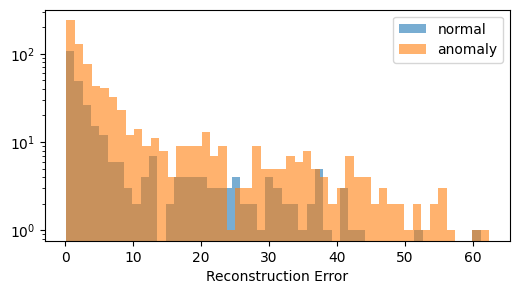

In [45]:
normal = np.array([s for s,l in zip(scores,labels) if l==0])
anom   = np.array([s for s,l in zip(scores,labels) if l==1])
plt.figure(figsize=(6,3))
plt.hist(normal, bins=50, alpha=0.6, label='normal', log=True)
plt.hist(anom, bins=50, alpha=0.6, label='anomaly', log=True)
plt.xlabel('Reconstruction Error')
plt.legend()
plt.show()

In [46]:
import os
import numpy as np
from glob import glob

FOLDER = 'DATA/embeddings_seq/test'  # or 'train'
EXPECTED_DIM = 768

invalid_files = []

for path in glob(os.path.join(FOLDER, '*.npy')):
    try:
        arr = np.load(path)
        if arr.ndim != 2 or arr.shape[1] != EXPECTED_DIM or arr.shape[0] == 0:
            print(f"❌ {os.path.basename(path)} has invalid shape: {arr.shape}")
            invalid_files.append(path)
    except Exception as e:
        print(f"⚠️ Error loading {path}: {e}")
        invalid_files.append(path)

if not invalid_files:
    print("✅ All files have valid shape (T, 768) and non-zero length.")


✅ All files have valid shape (T, 768) and non-zero length.


In [47]:
import os
import glob
import numpy as np
import torchaudio
import torch
from tqdm import tqdm

# Set paths
TEST_WAV_DIR = 'DATA/dev_data/dev_data/slider/test'
EMB_DIR = 'DATA/embeddings_seq/test'
os.makedirs(EMB_DIR, exist_ok=True)

# Load pretrained Wav2Vec2 model
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchaudio.pipelines import WAV2VEC2_BASE
wav2vec = WAV2VEC2_BASE.get_model().to(DEVICE)
wav2vec.eval()

# Get test WAV files
test_files = sorted(glob.glob(os.path.join(TEST_WAV_DIR, '*.wav')))

# Process each file
for wav_path in tqdm(test_files, desc="Regenerating test embeddings"):
    fname = os.path.basename(wav_path).replace('.wav', '.npy')
    out_npy = os.path.join(EMB_DIR, fname)

    # Regenerate if file is missing or invalid
    regenerate = False
    if not os.path.exists(out_npy):
        regenerate = True
    else:
        try:
            arr = np.load(out_npy)
            if arr.shape != (499, 768):  # Expected shape
                regenerate = True
        except:
            regenerate = True

    if regenerate:
        try:
            y, sr = torchaudio.load(wav_path)
            y = y.to(DEVICE)
            with torch.inference_mode():
                feats, _ = wav2vec(y)
            seq = feats.squeeze(0).cpu().numpy()
            np.save(out_npy, seq)
        except Exception as e:
            print(f"❌ Failed on {wav_path}: {e}")


Regenerating test embeddings: 100%|██████████| 1101/1101 [00:00<00:00, 1484.60it/s]
